# 基于在Mnist数据集上训练的手写数字生成模型的梯度提升试验
## 一、导入必要库并且配置GPU

In [1]:
from tensorflow import keras
import tensorflow.compat.v2.keras.backend as K
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import VGG16
import tensorflow as tf
from tensorflow.compat.v1 import disable_eager_execution
# disable_eager_execution()
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1 import ConfigProto, Session
import tensorflow.keras

config = ConfigProto(allow_soft_placement=True)

config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(Session(config=config))

## 二、配置网络
### （此处是导入预训练好的VGG16的Conv_base模型）

In [2]:
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
conv_base.trainable = False

In [3]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

### 加入一个密集分类器

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
model = Sequential()
model.add(
    conv_base
)
model.add(
    layers.Flatten()
)
model.add(
    layers.Dense(512, activation='relu')
)
model.add(
    layers.Dense(10, activation='softmax')
)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.Adagrad(lr=1e-2),
    metrics=['acc']
)

### 对 28x28的mnist数据集进行数据重塑（因为VGG16的Conv_base只能接受 32x32以上的数据）

In [5]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import tensorflow as tf
temp_img = ''
def resize_img(arrays):
    newImgList = np.zeros([arrays.shape[0], 32, 32])
    for i, img in enumerate(arrays):
        temp_img = image.array_to_img(img.reshape((28, 28, 1)))
        temp_img = temp_img.resize((32, 32))
        # temp_img = image.smart_resize(temp_img, (32, 32))
        newImgList[i] = image.img_to_array(temp_img).reshape(32, 32)
    return newImgList

X_train = resize_img(X_train)
X_test = resize_img(X_test)

In [6]:
def label2vector(label):
    vector = np.zeros([label.shape[0], 10])
    for i, j in enumerate(label):
        vector[i][j] = 1
    return vector
Y_train = label2vector(Y_train)
Y_test = label2vector(Y_test)

In [7]:
X_train = X_train.reshape([60000, 32, 32, 1])
X_train_temp = X_train
for i in range(2):
    X_train_temp = np.concatenate([X_train_temp, X_train], axis=3)

X_train = X_train_temp

### 开始训练模型

In [8]:
model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=128
)

Epoch 1/40
375/375 [==============================] - 17s 37ms/step - loss: 2.8588 - acc: 0.7842 - val_loss: 0.2222 - val_acc: 0.9282
Epoch 2/40
375/375 [==============================] - 13s 34ms/step - loss: 0.2026 - acc: 0.9367 - val_loss: 0.1853 - val_acc: 0.9398
Epoch 3/40
375/375 [==============================] - 13s 34ms/step - loss: 0.1628 - acc: 0.9474 - val_loss: 0.1750 - val_acc: 0.9431
Epoch 4/40
375/375 [==============================] - 13s 34ms/step - loss: 0.1372 - acc: 0.9558 - val_loss: 0.1596 - val_acc: 0.9482
Epoch 5/40
375/375 [==============================] - 13s 35ms/step - loss: 0.1225 - acc: 0.9613 - val_loss: 0.1459 - val_acc: 0.9528
Epoch 6/40
375/375 [==============================] - 14s 38ms/step - loss: 0.1119 - acc: 0.9655 - val_loss: 0.1386 - val_acc: 0.9557
Epoch 7/40
375/375 [==============================] - 14s 39ms/step - loss: 0.1044 - acc: 0.9674 - val_loss: 0.1392 - val_acc: 0.9544
Epoch 8/40
375/375 [==============================] - 15s 41ms

In [9]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
log_dir = '/home/oneran/Documents/TensorboardLog/' + str(datetime.datetime.now()) + '_VGG16+mnist_runtime_'

## 三、调整模型 （这里将初步训练的连接器和后两层Conv_block联合训练）

In [10]:
model.get_layer('vgg16').trainable = True

In [11]:
trainlabel = False
for layer in model.get_layer('vgg16').layers:
    if layer.name == 'block4_conv1':
        trainlabel = True
    layer.trainable = trainlabel 

In [12]:
model.compile(
    optimizer = optimizers.RMSprop(lr=1e-5),
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

In [13]:
X_train = X_train.astype('float32')

In [14]:
X_train.shape

(60000, 32, 32, 3)

In [15]:
log_dir += '1'
callback_tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[callback_tensorboard]
)

Epoch 1/50
375/375 [==============================] - 37s 87ms/step - loss: 0.0708 - acc: 0.9797 - val_loss: 0.0663 - val_acc: 0.9830
Epoch 2/50
375/375 [==============================] - 32s 86ms/step - loss: 0.0255 - acc: 0.9914 - val_loss: 0.0596 - val_acc: 0.9864
Epoch 3/50
375/375 [==============================] - 32s 85ms/step - loss: 0.0190 - acc: 0.9941 - val_loss: 0.0604 - val_acc: 0.9868
Epoch 4/50
375/375 [==============================] - 31s 84ms/step - loss: 0.0134 - acc: 0.9957 - val_loss: 0.0512 - val_acc: 0.9869
Epoch 5/50
375/375 [==============================] - 33s 87ms/step - loss: 0.0082 - acc: 0.9970 - val_loss: 0.0686 - val_acc: 0.9874
Epoch 6/50
375/375 [==============================] - 32s 86ms/step - loss: 0.0083 - acc: 0.9974 - val_loss: 0.0471 - val_acc: 0.9901
Epoch 7/50
375/375 [==============================] - 32s 85ms/step - loss: 0.0057 - acc: 0.9981 - val_loss: 0.0494 - val_acc: 0.9908
Epoch 8/50
375/375 [==============================] - 33s 88ms

In [16]:
X_test = X_test.reshape(len(X_test), 32, 32, 1)
X_test_temp = X_test.copy()
for i in range(2):
    X_test_temp = np.concatenate([X_test_temp, X_test], axis=3)

In [17]:
prediction = model.predict(X_test_temp)
argPre = np.argmax(prediction, axis=1)

### 最终测试精度

In [18]:
print('The test acc:', np.mean(argPre==np.argmax(Y_test, axis=1)))

The test acc: 0.9923


In [19]:
wrongIndex = np.where(argPre!=np.argmax(Y_test, axis=1))

### 识别错误的数据

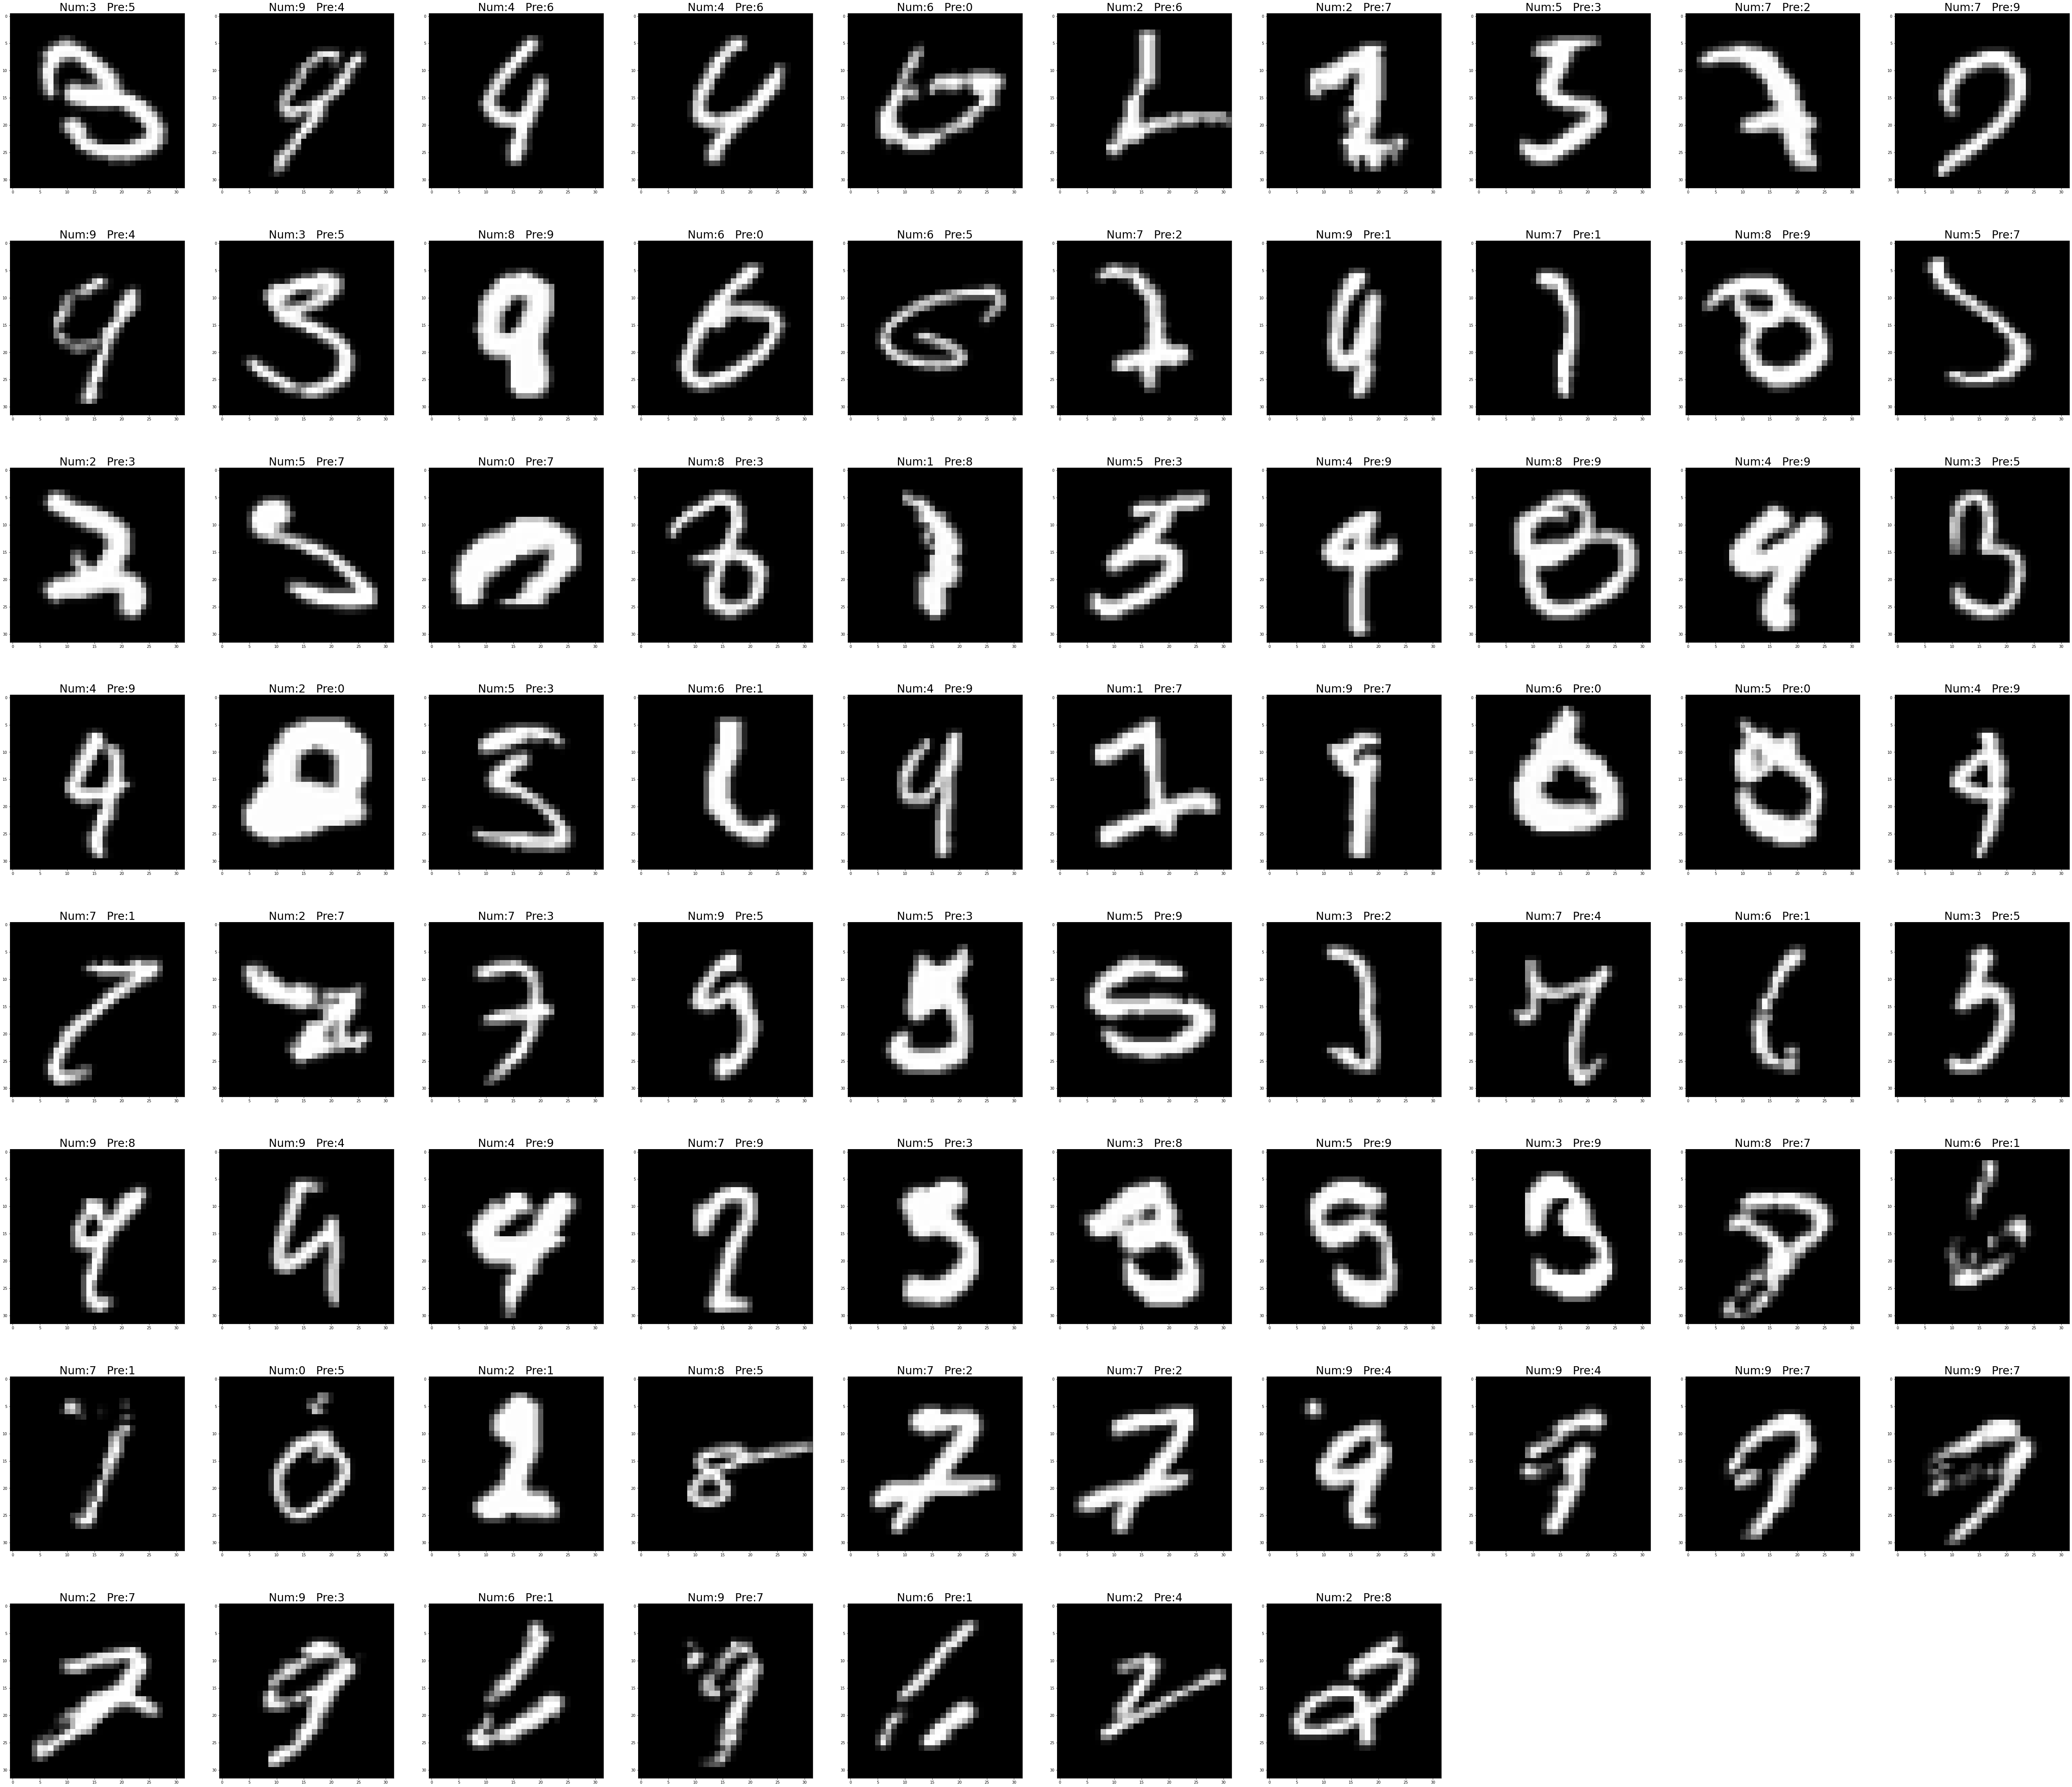

In [20]:
plt.figure(figsize=(100, 100))
for i, index in zip(range(len(wrongIndex[0])), wrongIndex[0]):
    plt.subplot(9, 10, i+1)
    wrongImg = image.array_to_img(X_test_temp[index])
    plt.imshow(wrongImg)
    plt.title('Num:' + str(np.argmax(Y_test[index])) + '   Pre:' + str(argPre[index]), fontsize=30)

In [21]:
from tensorflow.keras import models

OSError: SavedModel file does not exist at: /home/oneran/MODELS/mnist_VGG16.h5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
model.summary()

## 四、对训练好的模型进行梯度提升并且进行对抗实验

In [8]:
from tensorflow.keras.models import Model

In [9]:
def eval_loss_and_grads(tensor_in):
    outs = get_loss_and_grads(tensor_in)
    loss_value = outs[0]
    grads_value = outs[1]
    return loss_value, grads_value

def gradient_ascent(x, iteration, step, max_loss=None):
    for i in range(iteration):
        loss, grads = eval_loss_and_grads(x)
        if max_loss is not None and loss < max_loss:
            break
        # print('...Loss value at', i, ':', loss)
        x -= grads * step
    return x

-------------------------------------------


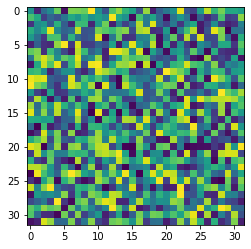

-------------------------------------------


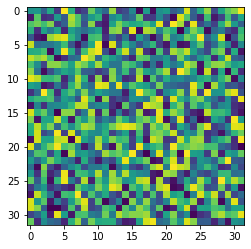

-------------------------------------------


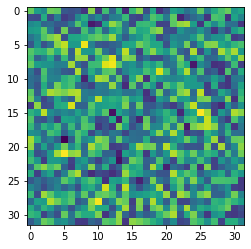

In [10]:
# from tensorflow.keras import backend as K
for i in range(3):
    zero = [0] * 10
    zero[i] = 1
    tensor_in = model.input
    tensor_out = model.get_layer('dense_1').output
    tensor_zero = K.variable(zero)
    loss = K.variable(0.)
    loss = K.sum(K.abs(K.square(tensor_out) - K.square(tensor_zero)), axis=1)           #降低loss
    grads = K.gradients(loss, tensor_in)[0]
    grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
    outputs = [loss, grads]
    get_loss_and_grads = K.function(tensor_in, outputs)

    iters = 1000
    step = 1
    max_loss = 0.1
    x = np.random.random((1, 32, 32, 3))*20 + 128
    img = gradient_ascent(x, iters, step, max_loss)
    img -= np.mean(img)
    img /= np.std(img)
    from tensorflow.keras.preprocessing import image
    from matplotlib import pyplot as plt
    # gray_img = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
    print('-------------------------------------------')
    plt.imshow(img[0,:,:,0])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


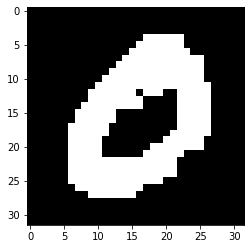

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


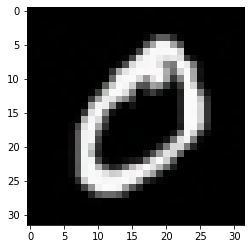

In [26]:
plt.imshow(X_train[1])
plt.show()
gan_img = img + X_train[1]
gan_img /=  (np.max(gan_img) - np.min(gan_img))
plt.imshow(gan_img[0])
plt.show()

In [27]:
model.predict(gan_img)

array([[0.46423066, 0.08366786, 0.00359169, 0.03637537, 0.23043755,
        0.09101451, 0.00615886, 0.0556957 , 0.01504499, 0.01378282]],
      dtype=float32)

In [13]:
np.mean(prediction==Y_test)

0.64166

In [19]:
Y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])